In [57]:
import os
import pandas as pd
from scipy import stats
import lingam
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from lingam.utils import make_dot
from tqdm import tqdm

In [2]:
df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'inputs', 'big_monthly_ret_etfs_macro_transf.csv'))
df.set_index('date', inplace=True)

des = pd.read_csv(os.path.join(os.getcwd(), 'data', 'utils', 'fredmd_description.csv'), sep=';')

df.head()

,SPY,XLI,XLE,XLK,XLV,XLU,XLF,XLY,XLP,XLB,...,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA
date,,,,,,,,,,,,,,,,,,,,,
2000-02-01,-0.021282,-0.079459,0.001764,-0.012479,0.026966,-0.015484,-0.023499,-0.092305,-0.002751,-0.122759,...,0.006116,-0.001597,0.002601,0.004109,0.004902,0.003639,0.003131,-0.002778,0.007243,0.002975
2000-03-01,-0.017010,-0.076506,-0.027588,0.096418,-0.090493,-0.053417,-0.096940,-0.104500,-0.104976,-0.134285,...,0.010111,0.003192,0.003112,0.006423,0.006701,0.006637,0.004292,0.001940,0.012709,0.001775
2000-05-01,-0.032612,0.055099,0.042422,-0.145227,-0.019337,0.079906,-0.004560,0.043250,0.107819,-0.007696,...,0.000000,0.003185,0.002581,0.001164,0.001215,0.001805,0.000836,0.000103,-0.001753,0.001923
2000-06-01,-0.004720,-0.003146,0.071931,-0.062907,-0.024226,0.004376,0.075222,-0.073864,0.042560,-0.021432,...,0.007380,-0.002388,0.004628,0.006957,0.006657,0.005992,0.003390,-0.003126,0.009124,0.002706
2000-08-01,-0.008866,0.019630,-0.040169,-0.056302,0.007473,0.005542,0.058110,0.020346,0.015038,-0.036369,...,-0.004013,-0.000798,0.003061,-0.000577,-0.001203,-0.000596,-0.000064,-0.004124,-0.005135,0.002607


In [3]:
etfs = ["SPY" ,"XLI" ,"XLE" ,"XLK" ,"XLV", "XLU" ,"XLF" ,"XLY" ,"XLP" ,"XLB"]
target = "SPY"

etfs.remove(target)
target_df = df.drop(etfs, axis=1)

### Compute forward looking correlation matrix

<Axes: >

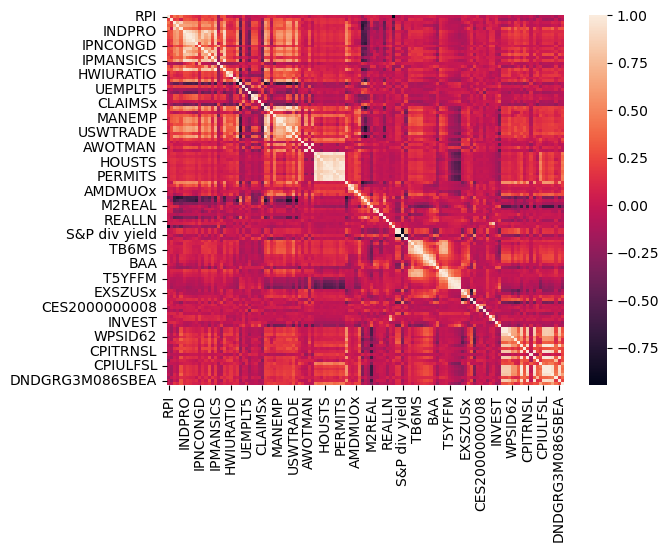

In [4]:
corr = target_df.drop([target], axis=1).corr()

sns.heatmap(corr)

### Find clusters using k-means

In [5]:
kmeans = KMeans(n_clusters=20, random_state=0, n_init="auto").fit(corr)

clusters_df = pd.DataFrame({"fred": target_df.drop([target], axis=1).columns, "cluster": kmeans.labels_})
clusters_df.sort_values(by="cluster")
clusters_df = pd.merge(clusters_df, des[["fred", "description"]], on='fred')

In [6]:
clusters_df.loc[clusters_df['cluster'] == 1]

,fred,cluster,description
71,S&P 500,1,S&P s Common Stock Price Index: Composite
72,S&P: indust,1,S&P s Common Stock Price Index: Industrials
94,EXUSUKx,1,U.S. / U.K. Foreign Exchange Rate
106,WPSID62,1,PPI: Crude Materials
107,OILPRICEx,1,"Crude Oil, spliced WTI and Cushing"
108,PPICMM,1,PPI: Metals and metal products:


### Model parameters

In [78]:
start_window = 12 * 8
p = 1
correl_window = 1000
min_periods = 12
beta_threshold = 0.05

### Compute rolling correlation of each time series within a cluster

In [79]:
correl_dict = {}
rank_list = []
for c in np.unique(kmeans.labels_):
    clustes_variables = clusters_df.loc[clusters_df['cluster'] == c]['fred'].values

    clusters_features_df = target_df[[target] + list(clustes_variables)]
    
    # compute rolling correlation
    rolling_corr_df = clusters_features_df.rolling(window=correl_window, min_periods=min_periods).corr()

    # compute correlation with the target
    rolling_corr_df = rolling_corr_df[[target]].reset_index()
    rolling_corr_df = rolling_corr_df.loc[rolling_corr_df["level_1"] != "SPY"]
    rolling_corr_df = rolling_corr_df.pivot_table(index=["date"], columns=["level_1"])
    rolling_corr_df.columns = rolling_corr_df.columns.droplevel()

    # save correl
    correl_dict[c] = rolling_corr_df

    # compute rankings given correl
    rank_df = rolling_corr_df.rank(axis=1, ascending=False)

    # save rank
    rank_list.append(rank_df)
final_rank_df = pd.concat(rank_list, axis=1)

### Compute rolling causal graph using VAR-LiNGAM

In [95]:
target_subset_df = target_df.iloc[(min_periods-1):, :]

start = 0
end = start + start_window

parents_of_target = []
for step in tqdm(range(0, len(target_subset_df) - start_window, 1), total=len(target_subset_df) - start_window, desc="rolling VAR-LiNGAM"):

    # select features and time window
    selected_columns = list(final_rank_df.iloc[(end + step)].index[(final_rank_df.iloc[(end + step)] == 1)])
    Xt = target_subset_df.iloc[start:(end + step), :][[target] + selected_columns]

    # run VARLiNGAM
    var_lingam = lingam.VARLiNGAM(lags=p)
    var_lingam_fit = var_lingam.fit(Xt)

    # build labels - ONLY WORKS FOR k=1
    labels0 = []
    labels1 = []
    for i in range(p+1):
        for colname in Xt.columns:
            if i == 0:
                labels0.append("{}(t)".format(colname, i))
            else:
                labels1.append("{}(t-{})".format(colname, i))

    B0 = var_lingam_fit.adjacency_matrices_[0]
    B1 = var_lingam_fit.adjacency_matrices_[1]

    B0_df = pd.DataFrame(B0, columns=labels0, index=labels0)
    B1_df = pd.DataFrame(B1, columns=labels1, index=labels0)

    selected_variables = list(B1_df.loc["SPY(t)"][np.abs(B1_df.loc["SPY(t)"]) > beta_threshold].index)
    parents_of_target.append(pd.DataFrame(1, index=selected_variables, columns=[Xt.index[-1]]).T)

    Xt_subset = []
    for varname_lag in selected_variables:
        varname = varname_lag.split("(t-")[0]
        lag = int(varname_lag.split("(t-")[1].replace(")", ""))

        tmp_feature_df = Xt[[varname]].shift(lag)
        Xt_subset.append(tmp_feature_df)
    Xt_subset = pd.concat([Xt[[target]], pd.concat(Xt_subset, axis=1)], axis=1).dropna()
parents_of_target_df = pd.concat(parents_of_target, axis=0)

rolling VARLiNGAM: 100%|██████████| 86/86 [00:58<00:00,  1.46it/s]


In [154]:
summary_parents_of_target_df = parents_of_target_df.sum().reset_index()
summary_parents_of_target_df.columns = ["feature_name", "count"]
summary_parents_of_target_df["fred"] = [name.split("(t")[0] for name in summary_parents_of_target_df["feature_name"]]
summary_parents_of_target_df = summary_parents_of_target_df[["fred", "feature_name", "count"]]

summary_parents_of_target_df = pd.merge(summary_parents_of_target_df, clusters_df, on="fred")
summary_parents_of_target_df = summary_parents_of_target_df.sort_values(by="cluster", ascending=False)

test_df = parents_of_target_df.reset_index().melt("index").rename(columns={"variable": "fred"})
test_df["fred"] = [name.split("(t")[0] for name in test_df["fred"]]

merge_test_cluster_df = pd.merge(test_df, clusters_df, on=["fred"])
stability_df = merge_test_cluster_df.pivot_table(index=["index"], columns=["cluster"], values=["value"]).fillna(0)

In [155]:
(stability_df.sum(axis=0) / stability_df.shape[0]).sort_values(ascending=False)

       cluster
value  1          1.000000
       11         1.000000
       14         1.000000
       9          0.988372
       19         0.953488
       17         0.918605
       5          0.906977
       12         0.872093
       2          0.837209
       3          0.802326
       10         0.686047
       18         0.267442
       15         0.244186
dtype: float64

In [156]:
clusters_df.loc[clusters_df["cluster"] == 9]

,fred,cluster,description
31,USGOOD,9,All Employees: Goods-Producing Industries
33,USCONS,9,All Employees: Construction
34,MANEMP,9,All Employees: Manufacturing
35,DMANEMP,9,All Employees: Durable goods
36,NDMANEMP,9,All Employees: Nondurable goods
39,USWTRADE,9,All Employees: Wholesale Trade


In [117]:
summary_parents_of_target_df.groupby("cluster")[["feature_name"]].count().sort_values(by="feature_name", ascending=False)

,feature_name
cluster,
2,4
5,3
1,2
3,2
11,2
12,2
17,2
9,1
10,1


In [114]:
summary_parents_of_target_df

,fred,feature_name,count,cluster,description
7,ACOGNO,ACOGNO(t-1),82.0,19,New Orders for Consumer Goods
12,DTCTHFNM,DTCTHFNM(t-1),23.0,18,Total Consumer Loans and Leases Outstanding
11,HWIURATIO,HWIURATIO(t-1),43.0,17,Ratio of Help Wanted/No. Unemployed
15,CPIAPPSL,CPIAPPSL(t-1),36.0,17,CPI : Apparel
13,AMDMNOx,AMDMNOx(t-1),21.0,15,New Orders for Durable Goods
6,DSERRG3M086SBEA,DSERRG3M086SBEA(t-1),86.0,14,Personal Cons. Exp: Services
18,M2SL,M2SL(t-1),18.0,12,M2 Money Stock
10,M1SL,M1SL(t-1),57.0,12,M1 Money Stock
19,W875RX1,W875RX1(t-1),15.0,11,Real personal income ex transfer receipts
5,RPI,RPI(t-1),71.0,11,Real Personal Income


In [22]:
# labels = []
# for i in range(p):
#     for colname in Xt.columns:
#         if i == 0:
#             labels.append("{}(t)".format(colname, i))
#         else:
#             labels.append("{}(t-{})".format(colname, i))

# make_dot(np.hstack(var_lingam_fit.adjacency_matrices_), ignore_shape=True, lower_limit=0.05, labels=labels)